<a href="https://colab.research.google.com/github/Shafiq-Abdu/abdulrahman.github.io/blob/main/Supertrend_Project_work_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install panda
!pip install numpy
!pip install matplotlib
!pip install yfinance
!pip install mplfinance

  Preparing metadata (setup.py) ... done
  Created wheel for panda: filename=panda-0.3.1-py3-none-any.whl size=7239 sha256=cb910261bd2d2e9ff74bcd76fd9c31857d8a8dc2fca3fd9662215f2767b6a5cb
  Stored in directory: /root/.cache/pip/wheels/0e/8b/c3/ff9cbde1fffd8071cff8367a86f0350a1ce30a8d31b6a432e9
Successfully built panda
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.2 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

## Fetch data, Define strategy, generate signals, create plots and examine strategy performance

In [ ]:
def fetch_asset_data(symbol, start_date, interval):
    # Fetch OHLCV data using yfinance
    asset_data = yf.download(symbol, start=start_date, interval=interval)
    # Convert the data to a DataFrame
    df = pd.DataFrame(asset_data)
    # Drop any rows with missing values
    df.dropna(inplace=True)
    return df

In [ ]:
def supertrend(df, atr_period=15, atr_multiplier=3):
    # Calculate the Upper Band(UB) and the Lower Band(LB)
    # Formula: Supertrend = (High + Low) / 2 + (Multiplier) * (ATR)
    current_average_high_low = (df['High'] + df['Low']) / 2

    # Calculate True Range (TR)
    df['tr1'] = df['High'] - df['Low']
    df['tr2'] = abs(df['High'] - df['Close'].shift())
    df['tr3'] = abs(df['Low'] - df['Close'].shift())
    df['tr'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)

    # Calculate ATR
    df['atr'] = df['tr'].rolling(window=atr_period).mean()

    # Drop temporary columns
    df.drop(['tr1', 'tr2', 'tr3', 'tr'], axis=1, inplace=True)

    df.dropna(inplace=True)
    df['basicUpperband'] = current_average_high_low + (atr_multiplier * df['atr'])
    df['basicLowerband'] = current_average_high_low - (atr_multiplier * df['atr'])
    first_upperBand_value = df['basicUpperband'].iloc[0]
    first_lowerBand_value = df['basicLowerband'].iloc[0]
    upperBand = [first_upperBand_value]
    lowerBand = [first_lowerBand_value]

    for i in range(1, len(df)):
        if df['basicUpperband'].iloc[i] < upperBand[i-1] or df['Close'].iloc[i-1] > upperBand[i-1]:
            upperBand.append(df['basicUpperband'].iloc[i])
        else:
            upperBand.append(upperBand[i-1])

        if df['basicLowerband'].iloc[i] > lowerBand[i-1] or df['Close'].iloc[i-1] < lowerBand[i-1]:
            lowerBand.append(df['basicLowerband'].iloc[i])
        else:
            lowerBand.append(lowerBand[i-1])

    df['upperband'] = upperBand
    df['lowerband'] = lowerBand
    df.drop(['basicUpperband', 'basicLowerband'], axis=1, inplace=True)

    return df


In [ ]:
def generate_signals(df):
    # Initialize a signals list
    signals = []

    # Loop through the dataframe
    for i in range(len(df)):
        if df['Close'][i] > df['upperband'][i]:
            signals.append(1)  # Buy signal
        elif df['Close'][i] < df['lowerband'][i]:
            signals.append(-1)  # Sell signal
        else:
            signals.append(0)  # No signal

    # Add the signals list as a new column in the dataframe
    df['signals'] = signals
    df['signals'] = df['signals'].shift(1)  # Remove look-ahead bias
    return df

In [ ]:
def create_positions(df):
    # Initialize positions lists
    buy_positions = [np.nan]
    sell_positions = [np.nan]

    # Loop through the dataframe
    for i in range(1, len(df)):
        # If the current signal is a 1 (Buy) and it's not equal to the previous signal
        # Then that is a trend reversal, so we BUY at that current market price
        if df['signals'][i] == 1 and df['signals'][i] != df['signals'][i - 1]:
            buy_positions.append(df['Close'][i])
            sell_positions.append(np.nan)
        # If the current signal is a -1 (Sell) and it's not equal to the previous signal
        # Then that is a trend reversal, so we SELL at that current market price
        elif df['signals'][i] == -1 and df['signals'][i] != df['signals'][i - 1]:
            sell_positions.append(df['Close'][i])
            buy_positions.append(np.nan)
        else:
            buy_positions.append(np.nan)
            sell_positions.append(np.nan)

    # Add the positions lists as new columns in the dataframe
    df['buy_positions'] = buy_positions
    df['sell_positions'] = sell_positions
    return df


In [ ]:
def plot_data(df, symbol):
    # Define lowerband line plot
    lowerband_line = mpf.make_addplot(df['lowerband'], label= "lowerband", color='green')
    # Define upperband line plot
    upperband_line = mpf.make_addplot(df['upperband'], label= "upperband", color='red')
    # Define buy and sell markers
    buy_position_makers = mpf.make_addplot(df['buy_positions'], type='scatter', marker='^', label= "Buy", markersize=80, color='#2cf651')
    sell_position_makers = mpf.make_addplot(df['sell_positions'], type='scatter', marker='v', label= "Sell", markersize=80, color='#f50100')
    # A list of all addplots(apd)
    apd = [lowerband_line, upperband_line, buy_position_makers, sell_position_makers]

    # Plot the data
    mpf.plot(df, addplot=apd, type='candle', volume=True, style='charles', xrotation=20, title=str(symbol + ' Supertrend Plot'),figscale=1.5)


In [ ]:
# def strategy_performance(strategy_df, capital=100, leverage=1):
#     # Initialize the performance variables
#     cumulative_balance = capital
#     investment = capital
#     pl = 0
#     max_drawdown = 0
#     max_drawdown_percentage = 0

#     # Lists to store intermediate values for calculating metrics
#     balance_list = [capital]
#     pnl_list = [0]
#     investment_list = [capital]
#     peak_balance = capital

#     # Loop from the second row (index 1) of the DataFrame
#     for index in range(1, len(strategy_df)):
#         row = strategy_df.iloc[index]

#         # Calculate P/L as a percentage of investment
#         if row['signals'] == 1:
#             pl = ((row['Close'] - row['Open']) / row['Open']) * leverage
#         elif row['signals'] == -1:
#             pl = ((row['Open'] - row['Close']) / row['Close']) * leverage
#         else:
#             pl = 0

#         # Update the investment if there is a signal reversal
#         if row['signals'] != strategy_df.iloc[index - 1]['signals']:
#             investment = cumulative_balance

#         # Calculate the new balance based on P/L
#         cumulative_balance += (pl * investment)

#         # Update the investment list
#         investment_list.append(investment)

#         # Calculate the cumulative balance and add it to the DataFrame
#         balance_list.append(cumulative_balance)

#         # Calculate the overall P/L and add it to the DataFrame
#         pnl_list.append(pl)

#         # Calculate max drawdown
#         drawdown = cumulative_balance - peak_balance
#         if drawdown < max_drawdown:
#             max_drawdown = drawdown
#             max_drawdown_percentage = (max_drawdown / peak_balance) * 100

#         # Update the peak balance
#         if cumulative_balance > peak_balance:
#             peak_balance = cumulative_balance

#     # Add new columns to the DataFrame
#     strategy_df['investment'] = investment_list
#     strategy_df['cumulative_balance'] = balance_list
#     strategy_df['pl'] = pnl_list
#     strategy_df['cumPL'] = strategy_df['pl'].cumsum()

#     # Calculate other performance metrics
#     overall_pl_percentage = (cumulative_balance - capital) * 100 / capital
#     overall_pl = cumulative_balance - capital
#     min_balance = min(balance_list)
#     max_balance = max(balance_list)
#     total_trades = len(strategy_df[strategy_df['signals'] != 0])

#     # Print the performance metrics
#     print("Overall P/L: {:.2f}%".format(overall_pl_percentage))
#     print("Overall P/L: {:.2f}".format(overall_pl))
#     print("Min balance: {:.2f}".format(min_balance))
#     print("Max balance: {:.2f}".format(max_balance))
#     print("Maximum Drawdown: {:.2f}".format(max_drawdown))
#     print("Maximum Drawdown %: {:.2f}%".format(max_drawdown_percentage))
#     print("Total Trades: {}".format(total_trades))

#     # Return the Strategy DataFrame
#     return strategy_df


In [ ]:

def strategy_performance(strategy_df, capital=100, leverage=1):
    # Initialize the performance variables
    cumulative_balance = capital
    investment = capital
    pl = 0
    max_drawdown = 0
    max_drawdown_percentage = 0
    max_profit = 0  # Initialize max_profit variable

    # Lists to store intermediate values for calculating metrics
    balance_list = [capital]
    pnl_list = [0]
    investment_list = [capital]
    peak_balance = capital
    drawdown_list = [0]  # List to store maximum drawdown at each iteration
    profit_list = [0]  # List to store profit at each iteration

    # Loop from the second row (index 1) of the DataFrame
    for index in range(1, len(strategy_df)):
        row = strategy_df.iloc[index]

        # Calculate P/L as a percentage of investment
        if row['signals'] == 1:
            pl = ((row['Close'] - row['Open']) / row['Open']) * leverage
        elif row['signals'] == -1:
            pl = ((row['Open'] - row['Close']) / row['Close']) * leverage
        else:
            pl = 0

        # Update the investment if there is a signal reversal
        if row['signals'] != strategy_df.iloc[index - 1]['signals']:
            investment = cumulative_balance

        # Calculate the new balance based on P/L
        cumulative_balance += (pl * investment)

        # Update the investment list
        investment_list.append(investment)

        # Calculate the cumulative balance and add it to the DataFrame
        balance_list.append(cumulative_balance)

        # Calculate the overall P/L and add it to the DataFrame
        pnl_list.append(pl)

        # Calculate max drawdown
        drawdown = cumulative_balance - peak_balance
        if drawdown < max_drawdown:
            max_drawdown = drawdown
            max_drawdown_percentage = (max_drawdown / peak_balance) * 100

        # Update the peak balance
        if cumulative_balance > peak_balance:
            peak_balance = cumulative_balance

        # Calculate profit
        profit = cumulative_balance - capital
        if profit > max_profit:
            max_profit = profit

        # Store the maximum drawdown at this iteration
        drawdown_list.append(max_drawdown)
        profit_list.append(profit)

    # Add new columns to the DataFrame
    strategy_df['investment'] = investment_list
    strategy_df['cumulative_balance'] = balance_list
    strategy_df['pl'] = pnl_list
    strategy_df['cumPL'] = strategy_df['pl'].cumsum()
    strategy_df['Max Drawdown'] = drawdown_list  # Add the maximum drawdown column
    strategy_df['Profit'] = profit_list  # Add the profit column

    # Calculate other performance metrics
    overall_pl_percentage = (cumulative_balance - capital) * 100 / capital
    overall_pl = cumulative_balance - capital
    min_balance = min(balance_list)
    max_balance = max(balance_list)
    total_trades = len(strategy_df[strategy_df['signals'] != 0])
    performance_metrics = pd.DataFrame({
        'Metric': ['Overall P/L %', 'Overall P/L', 'Min Balance', 'Max Balance', 'Max Drawdown', 'Max Drawdown %', 'Total Trades', 'Max Profit'],
        'Value': [f"{overall_pl_percentage:.2f}%", f"{overall_pl:.2f}", f"{min_balance:.2f}", f"{max_balance:.2f}", f"{max_drawdown:.2f}", f"{max_drawdown_percentage:.2f}%", total_trades, f"{max_profit:.2f}"]
    })


    # Print the performance metrics
    # print("Overall P/L: {:.2f}%".format(overall_pl_percentage))
    # print("Overall P/L: {:.2f}".format(overall_pl))
    # print("Min balance: {:.2f}".format(min_balance))
    # print("Max balance: {:.2f}".format(max_balance))
    # print("Maximum Drawdown: {:.2f}".format(max_drawdown))
    # print("Maximum Drawdown %: {:.2f}%".format(max_drawdown_percentage))
    # print("Total Trades: {}".format(total_trades))
    # print("Max Profit: {:.2f}".format(max_profit))  # Print max profit
    print(performance_metrics)
    # Return the Strategy DataFrame
    return strategy_df


In [ ]:
import matplotlib.pyplot as plt

def plot_performance_curve(strategy_df):
    # Plot the strategy performance curve
    plt.figure(figsize=(12, 6))
    plt.plot(strategy_df.index, strategy_df['cumulative_balance'], label='Strategy')
    plt.title('Performance Curve')
    plt.xlabel('Date')
    plt.ylabel('Balance')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

## Apply on symbols

In [ ]:
import mplfinance as mpf

[*********************100%%**********************]  1 of 1 completed


           Metric   Value
0   Overall P/L %  -1.16%
1     Overall P/L   -1.16
2     Min Balance   93.36
3     Max Balance  100.00
4    Max Drawdown   -6.64
5  Max Drawdown %  -6.64%
6    Total Trades      37
7      Max Profit    0.00


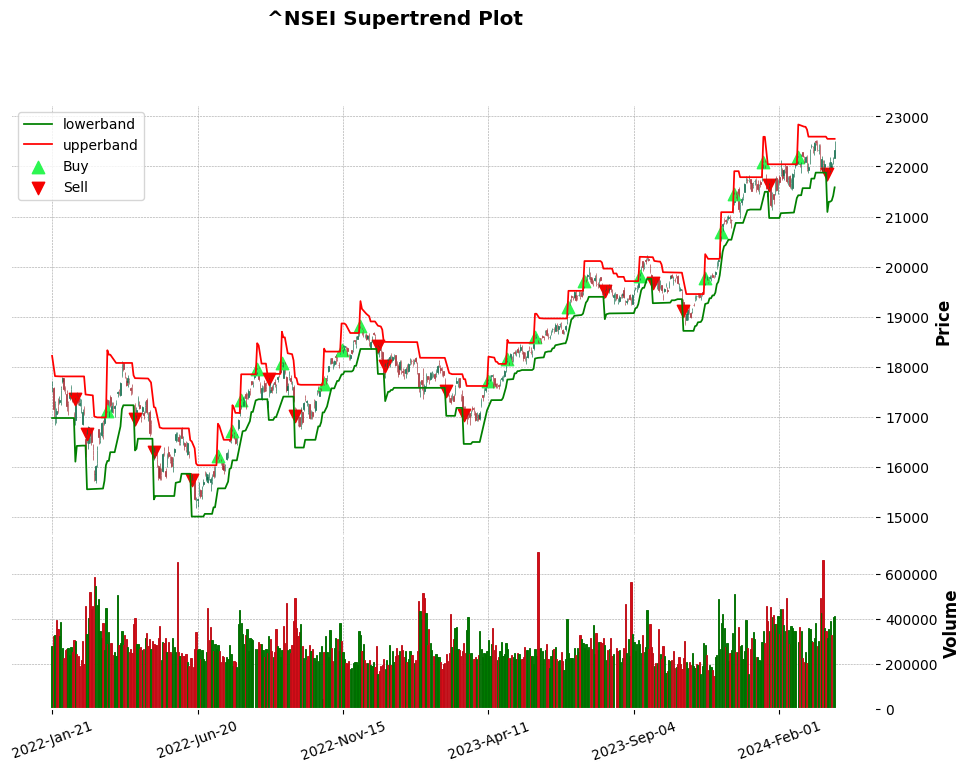

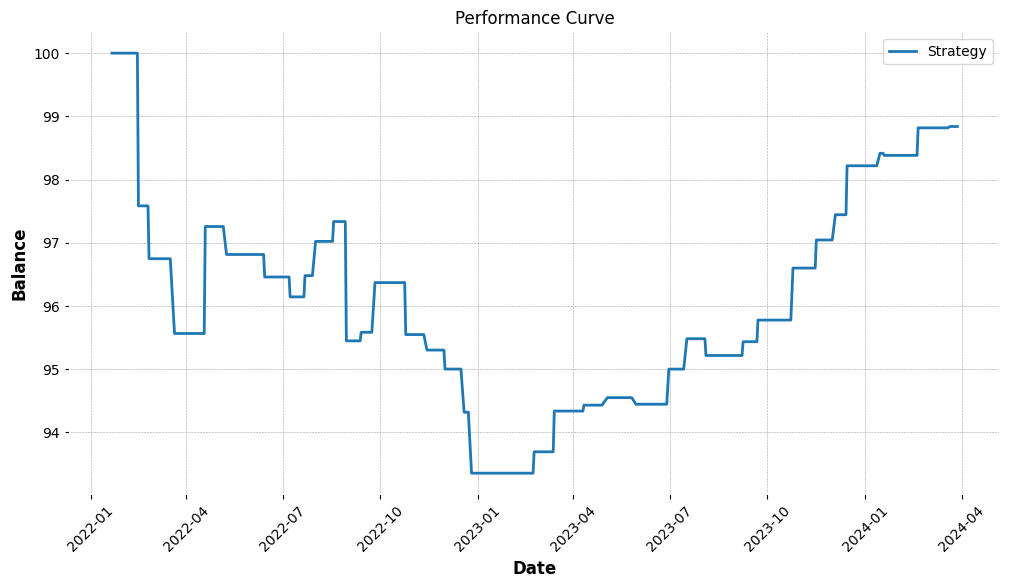

In [ ]:
symbol = '^NSEI'
data = yf.download(symbol, start='2022-01-01', end='2024-03-31')


    # Apply supertrend formula
supertrend_data = supertrend(data.copy())

# Generate the Signals
supertrend_positions = generate_signals(supertrend_data)

# Generate the Positions
supertrend_positions = create_positions(supertrend_positions)

# Calculate performance
supertrend_df = strategy_performance(supertrend_positions, capital=100, leverage=1)
# print(supertrend_df)
supertrend_df.to_csv(symbol+'supertrend_performance.csv', index=False)
# Plot data
plot_data(supertrend_positions, symbol=symbol)

# Plot the performance curve
plot_performance_curve(supertrend_df)

[*********************100%%**********************]  1 of 1 completed


           Metric   Value
0   Overall P/L %  -1.74%
1     Overall P/L   -1.74
2     Min Balance   93.36
3     Max Balance  100.00
4    Max Drawdown   -6.64
5  Max Drawdown %  -6.64%
6    Total Trades      37
7      Max Profit    0.00


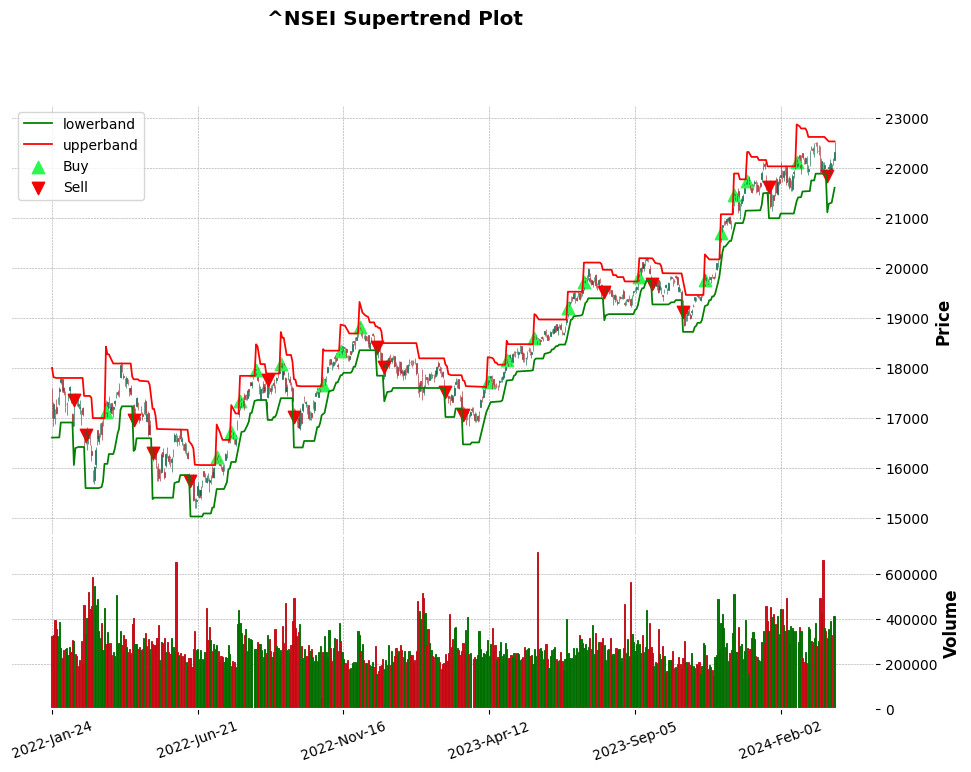

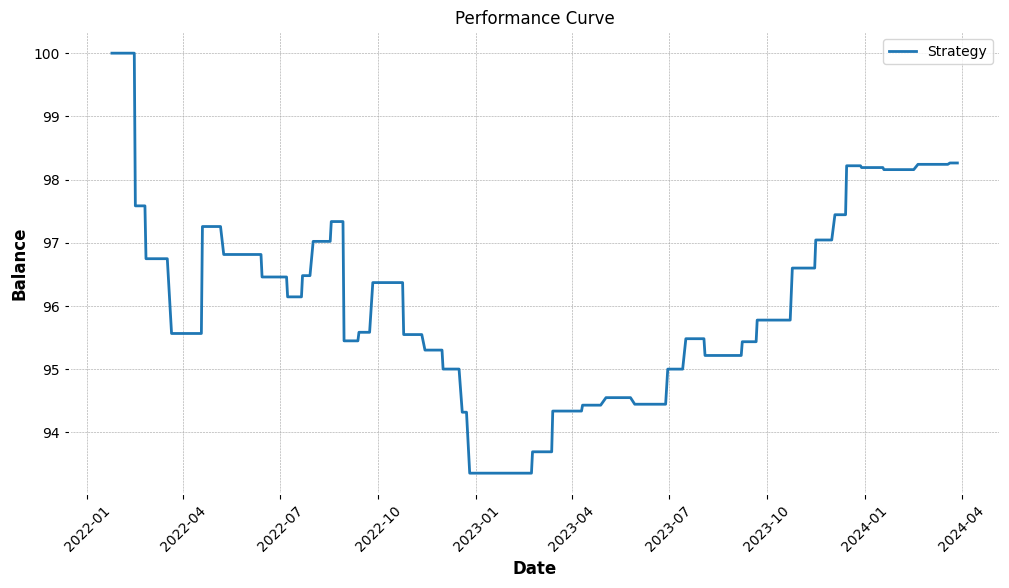

In [ ]:
symbol = '^NSEI'
data = yf.download(symbol, start='2022-01-01', end='2024-03-31')

    # Apply supertrend formula
supertrend_data = supertrend(data.copy(), atr_period=16, atr_multiplier=3)

# Generate the Signals
supertrend_positions = generate_signals(supertrend_data)

# Generate the Positions
supertrend_positions = create_positions(supertrend_positions)

# Calculate performance
supertrend_df = strategy_performance(supertrend_positions, capital=100, leverage=1)
# print(supertrend_df)
supertrend_df.to_csv(symbol+'supertrend_performance.csv', index=False)
# Plot data
plot_data(supertrend_positions, symbol=symbol)

# Plot the performance curve
plot_performance_curve(supertrend_df)

[*********************100%%**********************]  1 of 1 completed


           Metric   Value
0   Overall P/L %   8.25%
1     Overall P/L    8.25
2     Min Balance  100.00
3     Max Balance  111.96
4    Max Drawdown   -4.69
5  Max Drawdown %  -4.19%
6    Total Trades      37
7      Max Profit   11.96


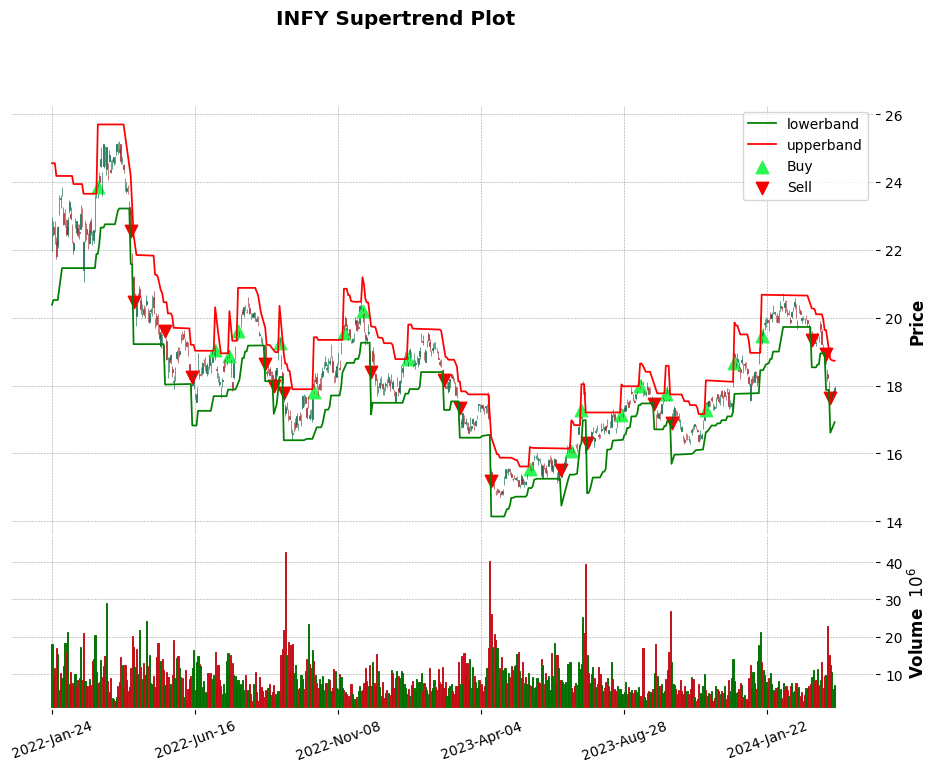

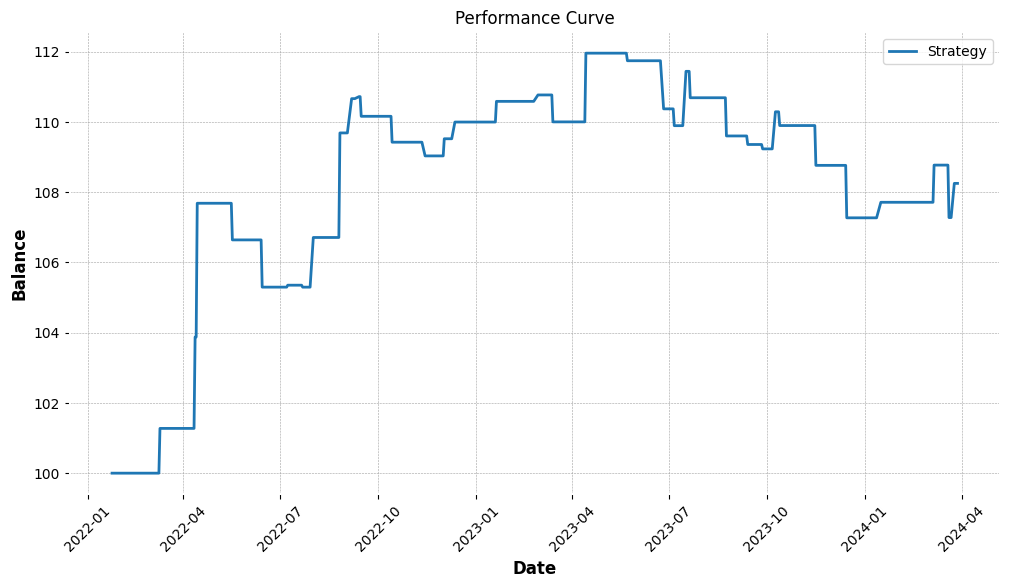

In [ ]:
symbol = 'INFY'
data = yf.download(symbol, start='2022-01-01', end='2024-03-31')


    # Apply supertrend formula
supertrend_data = supertrend(data.copy())

# Generate the Signals
supertrend_positions = generate_signals(supertrend_data)

# Generate the Positions
supertrend_positions = create_positions(supertrend_positions)

# Calculate performance
supertrend_df = strategy_performance(supertrend_positions, capital=100, leverage=1)
# print(supertrend_df)
supertrend_df.to_csv(symbol+'supertrend_performance.csv', index=False)
# Plot data
plot_data(supertrend_positions, symbol=symbol)

# Plot the performance curve
plot_performance_curve(supertrend_df)

[*********************100%%**********************]  1 of 1 completed


           Metric   Value
0   Overall P/L %   4.22%
1     Overall P/L    4.22
2     Min Balance   98.71
3     Max Balance  105.67
4    Max Drawdown   -1.61
5  Max Drawdown %  -1.54%
6    Total Trades      23
7      Max Profit    5.67


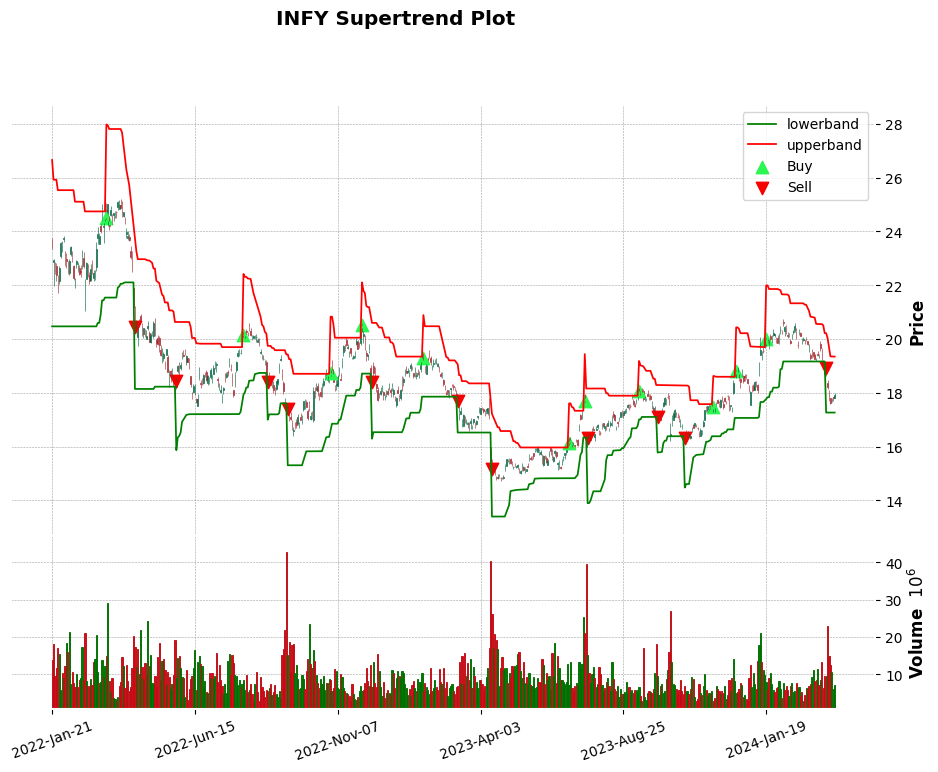

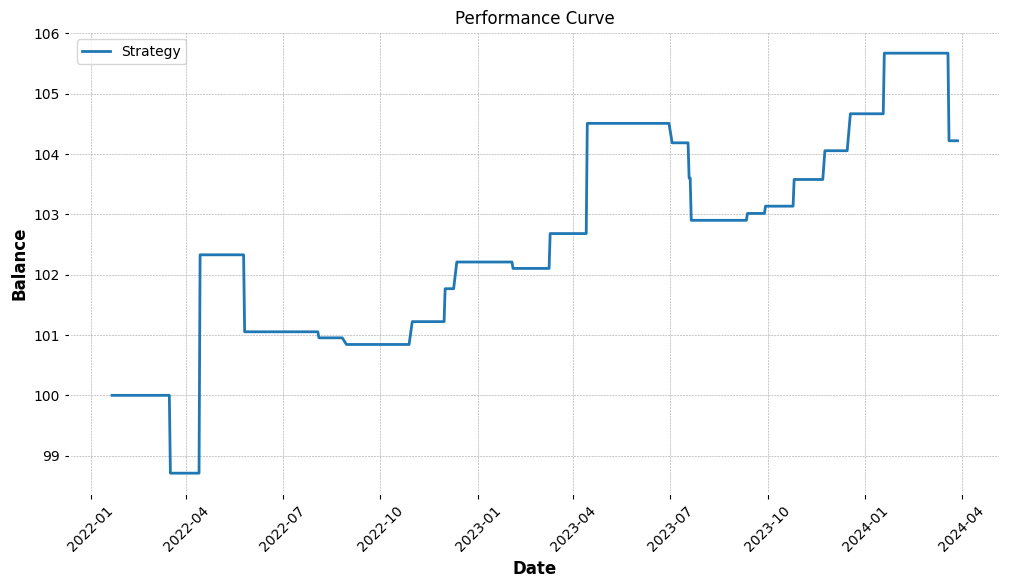

In [ ]:
symbol = 'INFY'
data = yf.download(symbol, start='2022-01-01', end='2024-03-31')


    # Apply supertrend formula
supertrend_data = supertrend(data.copy(), atr_period=14, atr_multiplier=4.82)

# Generate the Signals
supertrend_positions = generate_signals(supertrend_data)

# Generate the Positions
supertrend_positions = create_positions(supertrend_positions)

# Calculate performance
supertrend_df = strategy_performance(supertrend_positions, capital=100, leverage=1)
# print(supertrend_df)
supertrend_df.to_csv(symbol+'supertrend_performance.csv', index=False)
# Plot data
plot_data(supertrend_positions, symbol=symbol)

# Plot the performance curve
plot_performance_curve(supertrend_df)

[*********************100%%**********************]  1 of 1 completed


           Metric   Value
0   Overall P/L %  -2.34%
1     Overall P/L   -2.34
2     Min Balance   97.66
3     Max Balance  100.00
4    Max Drawdown   -2.34
5  Max Drawdown %  -2.34%
6    Total Trades      15
7      Max Profit    0.00


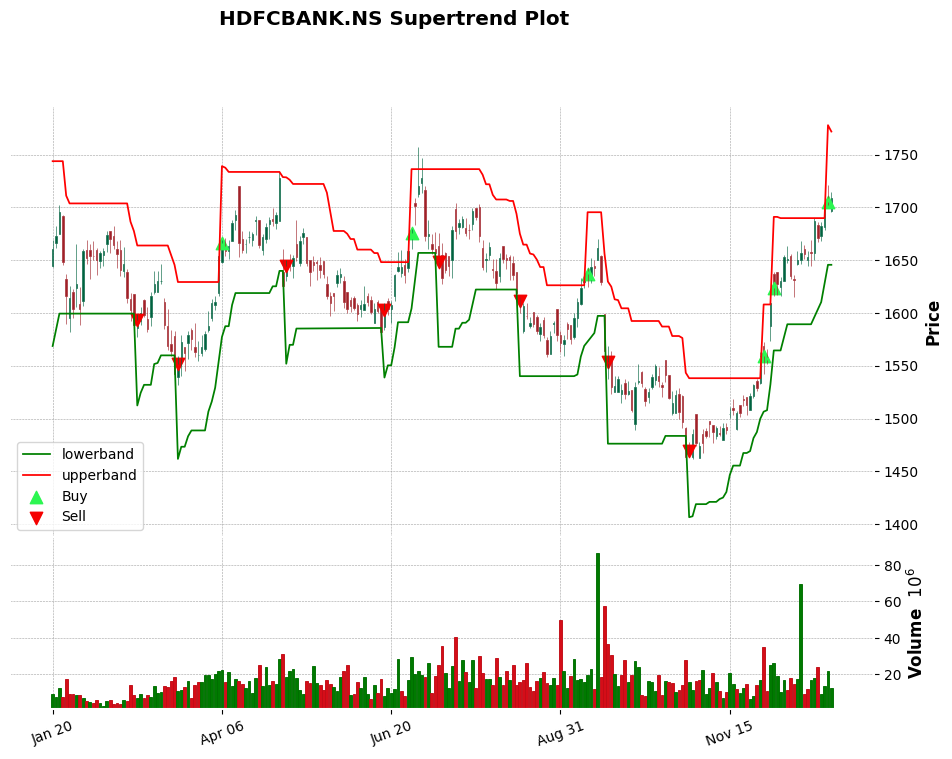

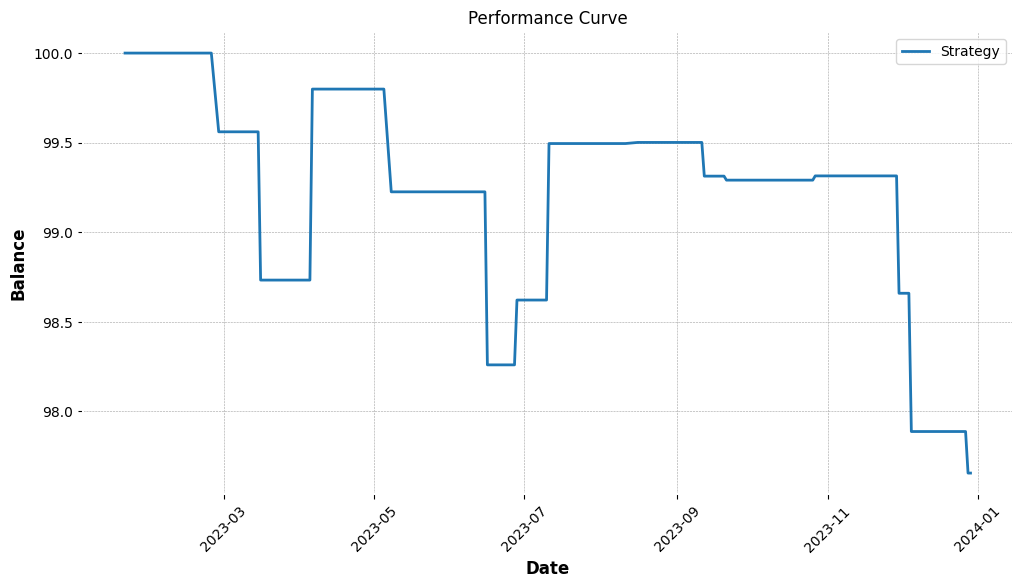

In [ ]:
symbol = 'HDFCBANK.NS'
data = yf.download(symbol, start='2023-01-01', end='2023-12-31')


    # Apply supertrend formula
supertrend_data = supertrend(data.copy())

# Generate the Signals
supertrend_positions = generate_signals(supertrend_data)

# Generate the Positions
supertrend_positions = create_positions(supertrend_positions)

# Calculate performance
supertrend_df = strategy_performance(supertrend_positions, capital=100, leverage=1)
# print(supertrend_df)
supertrend_df.to_csv(symbol+'supertrend_performance.csv', index=False)
# Plot data
plot_data(supertrend_positions, symbol=symbol)

# Plot the performance curve
plot_performance_curve(supertrend_df)